**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [27]:
import numpy as np
import sympy as sm
import math

from scipy import linalg
from scipy import optimize  

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from scipy import optimize

from IPython.display import display

from types import SimpleNamespace  

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

In [101]:
# write your code here

# Parameters (symbolic)
alpha   = sm.symbols('alpha')
kappa   = sm.symbols('kappa')
v       = sm.symbols('v')
tau     = sm.symbols('tau')
w       = sm.symbols('w')
wtilde  = sm.symbols('wtilde')

# Variables (symbolic)
U = sm.symbols('U')
C = sm.symbols('C')
G = sm.symbols('G')
L = sm.symbols('L')

# Baseline parameters
alpha_val = 0.5
kappa_val = 1.0
w_val = 1.0
v_val     = 1/(2*16**2)
tau_val   = 0.3
wtilde_val= 0.70 

# Functions
utility           = sm.log(C**alpha * G**(1-alpha)) - v * L**2 / 2

budget_constraint = sm.Eq(C,kappa + (1- tau)*w*L)

after_tax_wage    = sm.Eq(wtilde, (1-tau)*w)

print(f'Ultily is')
display(utility)
print('Budget constraint is')
display(budget_constraint)
print('After tax wage is') 
display(after_tax_wage)

Ultily is


-L**2*v/2 + log(C**alpha*G**(1 - alpha))

Budget constraint is


Eq(C, L*w*(1 - tau) + kappa)

After tax wage is


Eq(wtilde, w*(1 - tau))

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [14]:
#insert w(1-tau) into budget constraint
budget_constraint_subs = budget_constraint.subs((1-tau)*w, wtilde)
display(budget_constraint_subs)

# isolate C
C_from_budget_constraint_subs = sm.solve(budget_constraint_subs,C)
display(C_from_budget_constraint_subs[0])

# #insert into utility
utility_subs = utility.subs(C,C_from_budget_constraint_subs[0])
display(utility_subs)



Eq(C, L*wtilde + kappa)

L*wtilde + kappa

-L**2*v/2 + log(G**(1 - alpha)*(L*wtilde + kappa)**alpha)

In [15]:
# First order condition
foc = sm.diff(utility_subs,L)
foc_simple = sm.simplify(foc)
display(foc_simple)

(-L*v*(L*wtilde + kappa) + alpha*wtilde)/(L*wtilde + kappa)

In [16]:
# Set FOC equal to zero
L_eq = sm.Eq(foc_simple,0)
print('foc is')
display(L_eq)

sol = sm.solve(L_eq, L)

sol_positive = sol[1]

print('optimal labor supply is')
display(sol[1])

foc is


Eq((-L*v*(L*wtilde + kappa) + alpha*wtilde)/(L*wtilde + kappa), 0)

optimal labor supply is


(-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde)

-L**2*v/2 + log(G**(1 - alpha)*(L*wtilde + kappa)**alpha)

Eq(L, (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde))

log(G**(1 - alpha)*(kappa + (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v))**alpha) - (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))**2/(8*v*wtilde**2)

15.30165022719559


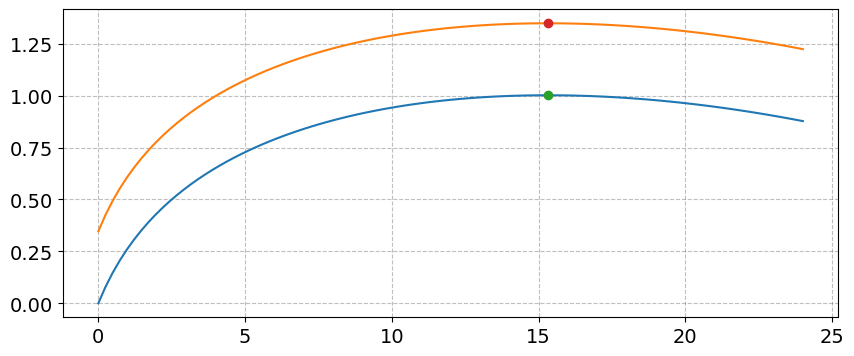

In [17]:
# Solution as equation
Lstar = sm.Eq(L,sol_positive)

display(utility_subs)
display(Lstar)

# Substitute Lstar into utility_subs
utility_subs_Lstar = utility_subs.subs(Lstar.lhs,Lstar.rhs)

display(utility_subs_Lstar)

# Lambdifing utility_subs_Lstar
Lstar_lamdafy      = sm.lambdify(args=(alpha,kappa,v,wtilde),expr = sol_positive)
utilify_func_Lstar = sm.lambdify(args=(alpha,kappa,v,G,wtilde),expr = utility_subs_Lstar)
utilify_func_L     = sm.lambdify(args=(alpha,kappa,v,G,wtilde,L),expr = utility_subs)

# data for plot
L_vec = np.linspace(0,24,100)

L_star_val = Lstar_lamdafy(alpha=alpha_val,kappa=kappa_val,v=v_val,wtilde=wtilde_val)

print(L_star_val)

utility_Lstar_1 = utilify_func_Lstar(alpha=alpha_val,kappa=kappa_val,v=v_val,G=1,wtilde=wtilde_val)
utility_Lstar_2 = utilify_func_Lstar(alpha=alpha_val,kappa=kappa_val,v=v_val,G=2,wtilde=wtilde_val)

utility_vec_1 = utilify_func_L(alpha=alpha_val,kappa=kappa_val,v=v_val,G=1,wtilde=wtilde_val,L=L_vec)
utility_vec_2 = utilify_func_L(alpha=alpha_val,kappa=kappa_val,v=v_val,G=2,wtilde=wtilde_val,L=L_vec)


fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.plot(L_vec,utility_vec_1)
ax.plot(L_vec,utility_vec_2)

# plot dot of 1 against Lstar_1
ax.plot(L_star_val,utility_Lstar_1,'o')
ax.plot(L_star_val,utility_Lstar_2,'o')


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

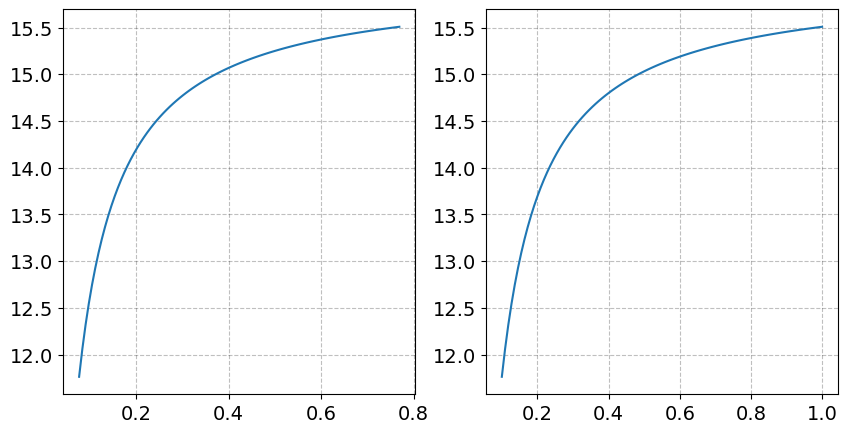

In [18]:
# Vector of possible after tax real wage values
wtilde_vec = np.linspace(0.1,1,100)

w_vec      = 1 / (1 + tau_val) * wtilde_vec 

L_star_vec = Lstar_lamdafy(alpha=alpha_val,kappa=kappa_val,v=v_val,wtilde=wtilde_vec)

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(w_vec,L_star_vec)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(wtilde_vec,L_star_vec)



We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


**Plot implied L for a grid of tau values**

In [202]:
Government4 = utility.subs(Government3.lhs, Government3.rhs)
Government5 = Government4.subs(budget_constraint.lhs, budget_constraint.rhs)
Government5 = sm.Eq(Government5, 0)
display(Government5)
Gov = sm.solve(Government5,L)



Eq(-L**2*v/2 + log((tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))**(1 - alpha)*(L*w*(1 - tau) + kappa)**alpha), 0)

KeyboardInterrupt: 

**Plot G for a grid of tau values**

Eq(G, L*tau*w)

Eq(G, tau*w*(-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde))

Eq(G, tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))

<lambdifygenerated-41>:2: RuntimeWarning: invalid value encountered in divide
  return equal(G, (1/2)*tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(v*(1 - tau)))


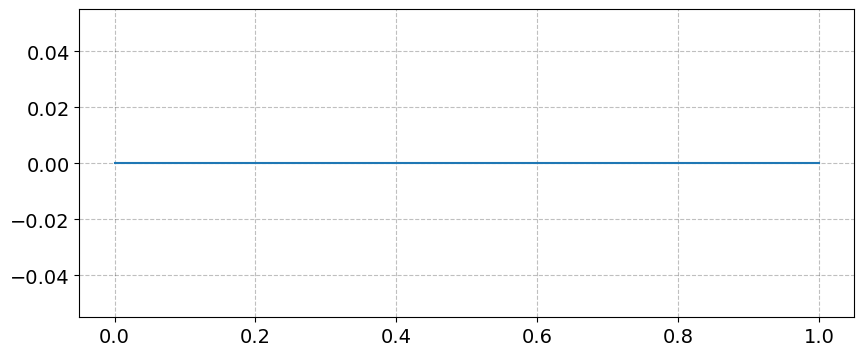

In [157]:
# Government consumption 
L_st = sm.symbols('L_st')

Government1 = sm.Eq(G, tau*w*L)
display(Government1)

#Insert L* in government consumption
Goverment2= Government1.subs(Lstar.lhs, Lstar.rhs)
display(Goverment2)

# substitute w with w tilde
Government3 = Goverment2.subs(wtilde, (1-tau)*w)
display(Government3)

#government consumption is a function of w hat... 
tau_vec = np.linspace(0,1,100)

government_lambdify = sm.lambdify(args=(alpha, kappa, v, tau, w), expr = Government3)
government = government_lambdify(alpha=alpha_val, kappa=kappa_val, v=v_val, w=w_val, tau=tau_vec)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,government)

**Plot worker utility for a grid of tau values**

In [198]:
Worker_disutility = sm.solve(Government3, v)
display(Worker_disutility[0])



alpha*tau**2*w**2*(tau - 1)/(G*(G*tau - G - kappa*tau))

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

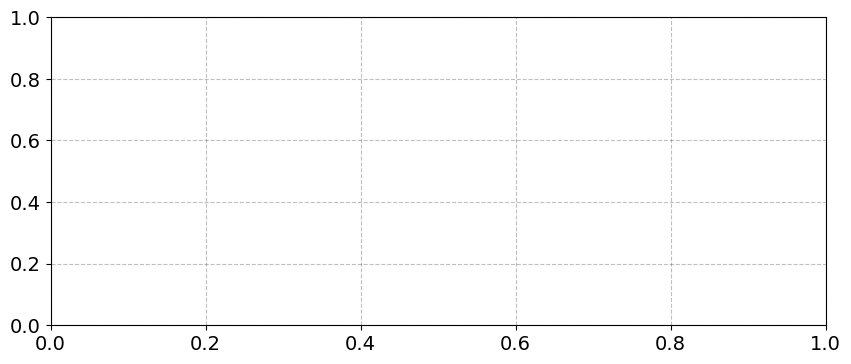

In [201]:

Lambda_disutility = sm.lambdify(args=(alpha, kappa, v, tau, w, G), expr = Worker_disutility)
disutility = Lambda_disutility(alpha=alpha_val, kappa=kappa_val, v=v_val, tau=tau_val, w=w_val, G=1)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,disutility)

In [165]:
GovernmentL = sm.Eq(G, tau*w*L*((1-tau)*w))
display(GovernmentL)


Eq(G, L*tau*w**2*(1 - tau))

In [ ]:

Government_L = government_lambdify(alpha=alpha_val, kappa=kappa_val, v=v_val, w=w_val, L=L_vec)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.plot(L_vec,Government_L)

Noter: 
- du har defineret med L, men det skal være L_star

plot worker utility
- definer government func
- insæt denne i utility func
- lambdify
- varier mht. tau

In [53]:
# tag function fra sympy og lambdify...

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [54]:
# 2 trinsoptimering... 

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [55]:
# write your code here

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [56]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [57]:
# write your code here

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [58]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [59]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [60]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [61]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [62]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [63]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [64]:
# write your code here